# 準備

In [1]:
# Pythonライブラリのロード
from __future__ import annotations
from typing import List, Tuple, Optional
import os
import subprocess
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.stats import expon
from neologdn import normalize as neonorm
from MeCab import Tagger
from gensim.models import KeyedVectors
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from skorch import NeuralNetClassifier
from skorch.callbacks import LRScheduler, EarlyStopping
from transformers import AutoModel, AutoTokenizer
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 基本となるフォルダ名
BASE_FOLDER: str = '.'
# Livedoor ニュースコーパスがあるフォルダ名
LIVEDOOR_NEWS_CORPUS_FOLDER: str = f'{BASE_FOLDER}/livedoor_news_corpus'
# Livedoor ニュースコーパスを処理したアウトプット
LIVEDOOR_NEWS_CORPUS_OUTPUT: str = f'{LIVEDOOR_NEWS_CORPUS_FOLDER}/news.jsonl'

In [3]:
# 第１日目の結果を読み込む
data = list()
with open(LIVEDOOR_NEWS_CORPUS_OUTPUT, 'rt') as rf:
    line = rf.readline()
    while line:
        data.append(json.loads(line.strip()))
        line = rf.readline()

In [4]:
# カテゴリ名をエンコード（0, 1, 2,... の値に）する
categories = [d['category'] for d in data]
le = LabelEncoder().fit(categories)
labels = le.transform(categories)
[(i, c) for i, c in enumerate(le.classes_)]

[(0, 'kaden-channel'), (1, 'movie-enter'), (2, 'sports-watch')]

In [5]:
# ベクトルを Pandas DataFrame 形式にする
document_ids = [d['id'] for d in data]
vectors = [d['vector'] for d in data]
vectors = pd.DataFrame(
    vectors,
    columns=[f'x{d:03}' for d in range(300)],
    index=document_ids
)

In [6]:
# 列は300次元のベクトルにおける各要素
# 行はニュースのID
vectors.iloc[:3, :10]

,x000,x001,x002,x003,x004,x005,x006,x007,x008,x009
4597641,-0.015517,0.023329,0.019360,-0.034291,-0.013400,-0.027293,0.002184,-0.013212,-0.002111,-0.033541
4601248,-0.006274,0.023792,0.025359,-0.037023,-0.015833,-0.013088,-0.008618,-0.018883,-0.004426,-0.032753
4604621,-0.008321,0.028338,0.018762,-0.003847,-0.023703,-0.011815,0.009208,-0.022022,-0.007412,-0.033149


# Support Vector Machine による分類

## Support Vector Machine による学習

In [7]:
# 学習用データと検証用データに分割
X_train, X_test, y_train, y_test = train_test_split(
    vectors, labels, test_size=0.3, random_state=12,
    stratify=labels
)

In [8]:
# サイズを確認
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1843, 300), (791, 300), (1843,), (791,))

In [9]:
# Hyper Parameter Search & Cross Validation
svc_params = {
    'C': expon(scale=1),  # 分布を表す関数を指定することも出来る
    'class_weight': [None, 'balanced'],  # リストを与えることも出来る
}
svc = LinearSVC(penalty='l2', max_iter=1000, random_state=12)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)
rcv = RandomizedSearchCV(
    svc, svc_params, cv=skf, scoring='f1_macro',
    n_iter=10, n_jobs=-1, refit=True, random_state=12
).fit(X_train, y_train)

## Support Vector Machine の学習結果

In [10]:
# 最適だと思われる Hyper Parameter の値
pd.DataFrame([
    {'Hyper Parameter': k, 'value': v} for k, v in rcv.best_params_.items()
])

,Hyper Parameter,value
0,C,2.886432
1,class_weight,balanced


In [11]:
# 学習用データで予測結果の精度を評価する
pred_train = rcv.best_estimator_.predict(X_train)
# 各種指標の計算
pd.DataFrame(classification_report(
    y_train, pred_train, output_dict=True,
    target_names=le.classes_
)).T

,precision,recall,f1-score,support
kaden-channel,0.984950,0.975166,0.980033,604.000000
movie-enter,0.980360,0.983580,0.981967,609.000000
sports-watch,0.988959,0.995238,0.992089,630.000000
accuracy,0.984807,0.984807,0.984807,0.984807
macro avg,0.984756,0.984661,0.984696,1843.000000
weighted avg,0.984804,0.984807,0.984793,1843.000000


In [12]:
# 学習用データの正解・不正解を可視化する
pd.DataFrame(
    confusion_matrix(y_train, pred_train).T,
    index=[f'predicted {x}' for x in le.classes_],
    columns=[f'{x} actually' for x in le.classes_]
)

,kaden-channel actually,movie-enter actually,sports-watch actually
predicted kaden-channel,589,7,2
predicted movie-enter,11,599,1
predicted sports-watch,4,3,627


## Support Vector Machine の精度評価

In [13]:
# 検証用データで予測結果の精度を評価する
pred_test = rcv.best_estimator_.predict(X_test)
# 各種指標の計算
pd.DataFrame(classification_report(
    y_test, pred_test, output_dict=True,
    target_names=le.classes_
)).T

,precision,recall,f1-score,support
kaden-channel,0.996078,0.976923,0.986408,260.00000
movie-enter,0.984848,0.996169,0.990476,261.00000
sports-watch,0.992647,1.000000,0.996310,270.00000
accuracy,0.991150,0.991150,0.991150,0.99115
macro avg,0.991191,0.991031,0.991065,791.00000
weighted avg,0.991202,0.991150,0.991130,791.00000


In [14]:
# 検証用データの正解・不正解を可視化する
pd.DataFrame(
    confusion_matrix(y_test, pred_test).T,
    index=[f'predicted {x}' for x in le.classes_],
    columns=[f'{x} actually' for x in le.classes_]
)

,kaden-channel actually,movie-enter actually,sports-watch actually
predicted kaden-channel,254,1,0
predicted movie-enter,4,260,0
predicted sports-watch,2,0,270


# TextCNN による分類

## テキストを TextCNN に入力するための前処理

In [15]:
# Word2Vec を行うクラス
class Vectorizer:
    def __init__(self: Vectorizer, unknown_index: int = 0) -> None:
        self.kvs = self._load_kvs()
        self.unknown_index = unknown_index
        return

    def _load_kvs(self: Vectorizer) -> KeyedVectors:
        '''Word2Vec形式のバイナリをロードする
        '''
        # バイナリのパス
        bin_fn = 'kv_fasttext_jawiki.bin'
        return KeyedVectors.load_word2vec_format(bin_fn, binary=True)

    def get_index(self: Vectorizer, word: str) -> int:
        '''単語の番号（インデックス）を返す

        Args:
            word (str): 単語

        Returns:
            int: インデックス。学習していない単語だったら unknown_index を返す
        '''
        try:
            index = self.kvs.index_to_key.index(word) + 1
        except Exception:
            index = self.unknown_index
        return index

In [16]:
# 形態素解析を行うクラス
class Tokenizer:
    # MeCab 辞書として、IPA辞書・JUMAN辞書・IPA NEologd辞書の３種類に対応
    INSTALLED_DICTIONARIES: List[str] = ['ipa', 'juman', 'neologd']

    def __init__(
        self: Tokenizer,
        max_word_len: int = 512,
        unknown_index: int = 0,
        dictionary: Optional[str] = None
    ) -> None:
        if dictionary is not None:
            self.dictionary = dictionary
        else:
            # 設定が無い場合はIPA辞書を用いる
            self.dictionary = 'ipa'
        self._load_mecab()
        self.max_word_len = max_word_len
        self.vectorizer = Vectorizer(unknown_index=unknown_index)
        return

    def _load_mecab(self: Tokenizer) -> None:
        '''MeCab辞書のパスや設定ファイルの場所を特定して、
        形態素解析を行うTaggerをロードする
        '''
        if os.path.isdir(self.dictionary):
            # load local dictionary
            print(f'loading local dictionary: {self.dictionary}')
            self.tagger = Tagger(f'-d {self.dictionary}')
            return
        elif self.dictionary not in self.INSTALLED_DICTIONARIES:
            raise ValueError(f'dictionary not found: {self.dictionary}')
        # load installed dictionary
        mecab_config_path = None
        # retrive the directory of dictionary
        mecab_config_cands = [
            '/usr/bin/mecab-config', '/usr/local/bin/mecab-config'
        ]
        for c in mecab_config_cands:
            if os.path.exists(c):
                mecab_config_path = c
                break
        if mecab_config_path is None:
            raise SystemError(
                'mecab-config not found. check mecab is really installed'
            )
        dic_dir = subprocess.run(
            [mecab_config_path, '--dicdir'],
            check=True, stdout=subprocess.PIPE, text=True
        ).stdout.rstrip()
        # retrive the dictonary
        dic_path = None
        if self.dictionary == 'ipa':
            dic_cands = ['ipadic-utf8', 'ipadic']
        elif self.dictionary == 'juman':
            dic_cands = ['juman-utf8', 'jumandic']
        else:  # self.dictionary == 'neologd'
            dic_cands = ['mecab-ipadic-neologd']
        for c in dic_cands:
            tmpdir = os.path.join(dic_dir, c)
            if os.path.isdir(tmpdir):
                dic_path = tmpdir
                break
        if dic_path is None:
            raise SystemError(
                f'installed dictionary not found: {self.dictionary}'
            )
        # create tagger
        print(f'loading installed dictionary: {self.dictionary}')
        self.tagger = Tagger(f'-d {dic_path}')
        return

    def tokenize(self: Tokenizer, sentence: str) -> List[int]:
        '''形態素解析（文章を単語に切る）を行う
        単語を Vectorizer のインデックスに変換し、その配列を返す

        Args:
            sentence (str): 解析したい（単語に切り分けたい）文章

        Returns
            List[str]: 単語のリスト
        '''
        # 文章の長さが 0 だったら、空のリストを返す
        if len(sentence) == 0:
            return []
        # 単語のリストを保存する変数
        words = list()
        # 形態素解析して、出力を行毎に分割した配列にする
        nodes = self.tagger.parse(sentence).splitlines()
        for node in nodes:
            node = node.strip()
            # 文章の終了（EOS: End Of Sentence）だったら終了
            if node == 'EOS':
                break
            # 表層型（文章に出てくる形）と単語の特徴に分解
            surface, feature_str = node.strip().split('\t', 1)
            # 特徴をリストに変換
            features = feature_str.split(',')
            # 単語をインデックスに変換し、リストに追加
            words.append(
                self.vectorizer.get_index(
                    self._get_word(surface=surface, features=features)
                )
            )
            if len(words) > self.max_word_len:
                break
        # 単語のリストを返す
        return words

    def _get_word(
        self: Tokenizer,
        surface: str,
        features: List[str]
    ) -> str:
        '''利用したい単語を返す
        ここでは最も基本として、表層型をそのまま返す
        Args:
            surface (str): 単語の表層型（文章に出てくる形）
            features (List[str]): 単語の特徴のリスト

        Returns:
            str: 利用したい単語
        '''
        if len(features) < 8:
            return surface
        return features[6]

In [17]:
class Preprocessor:
    '''文章の前処理をするクラス
    '''
    UNKNOWN_INDEX = 0
    MAX_WORD_LEN = 512

    def __init__(self: Preprocessor) -> None:
        self.tokenizer = Tokenizer(
            max_word_len=self.MAX_WORD_LEN,
            unknown_index=self.UNKNOWN_INDEX
        )
        return

    def preprocess(self: Preprocessor, text: str) -> List[int]:
        '''テキストから TextCNN に投入するデータ（単語インデックスの配列）を作る

        Args:
            text (str): 変換したい文章

        Returns:
            List[int]:
                文章を単語に区切り、その単語をインデックス（番号）に変換したもの
        '''
        indexes = list()
        for line in text.splitlines():
            # 正規化
            line = neonorm(line.strip())
            # 文を単語に切り分け、それをインデックス（番号）に変換する
            raw_indexes = self.tokenizer.tokenize(line)
            indexes.extend(raw_indexes)
            if len(indexes) >= self.MAX_WORD_LEN:
                break
        if len(indexes) >= self.MAX_WORD_LEN:
            # 長すぎる場合は、切り落とし
            indexes = indexes[:self.MAX_WORD_LEN]
        else:
            # 短すぎる場合は、UNKNOWN で埋める
            indexes = indexes + (
                [self.UNKNOWN_INDEX] * (self.MAX_WORD_LEN - len(indexes))
            )
        return indexes

In [18]:
preprocessor = Preprocessor()

loading installed dictionary: ipa


In [19]:
# どのように変換されるかの例
np.array(
    preprocessor.preprocess('吾輩は猫である。')
)[:8]

array([211885,      6,   4370,     14,     17,      3,      0,      0])

In [20]:
# テキストデータを変換する
preprocessed_texts = list()
for d in tqdm(data):
    preprocessed_texts.append(
        preprocessor.preprocess(d['contents'])
    )
preprocessed_texts = np.array(preprocessed_texts)

100%|███████████████████████████████████████| 2634/2634 [05:20<00:00,  8.21it/s]


## TextCNN の実装と学習

In [21]:
# 学習用データと検証用データに分割
X_train, X_test, y_train, y_test = train_test_split(
    preprocessed_texts, labels, test_size=0.3, random_state=12,
    stratify=labels
)

In [22]:
# サイズの確認
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1843, 512), (791, 512), (1843,), (791,))

In [23]:
# TextCNN の実装
class TextCNN(nn.Module):
    '''TextCNN: Convolutinal Neural Networks for text
    https://arxiv.org/abs/1408.5882

    Args:
        word_vectors (np.adarray): list of word vectors
        num_class (int): number of classes
        kernels (List[Tuple[int, int]]):
            kernels of Convolutional Layer
            each kernel is represented as
            ( number_of_output_channel, kernel size(N-gram) )
        word_len (Optional[int]):
            number of words in a sentence.
            each input sentence must be padded with <UNK> to be this length
            (default: 512)
        drop_prob (Optional[float]): probability of dropout (default: 0.5)
        input_channel (Optional[str]):
            type of input channel
            ('single' or 'multi', default: 'multi')
        random_state (Optional[int]): random seed (default: None)
    '''
    DEFAULT_WORD_LEN: int = 512
    DEFAULT_DROP_PROB: float = 0.5
    UNKNOWN_INDEX: int = 0
    INPUT_CHANNELS: List[str] = ['single', 'multi']
    DEFAULT_INPUT_CHANNEL: str = 'single'

    def __init__(
        self: TextCNN,
        word_vectors: np.ndarray,
        num_class: int,
        kernels: List[Tuple[int, int]],
        word_len: Optional[int] = None,
        drop_prob: Optional[float] = None,
        input_channel: Optional[str] = None,
        random_state: Optional[int] = None
    ) -> None:
        # initialize parent class
        super().__init__()
        # check parameters
        if num_class < 2:
            raise ValueError('num_class is invalid')
        else:
            self.num_class = num_class
        if word_len is None:
            self.word_len = self.DEFAULT_WORD_LEN
        elif word_len < 1:
            raise ValueError('word_len is invalid')
        else:
            self.word_len = word_len
        if drop_prob is None:
            self.drop_prob = self.DEFAULT_DROP_PROB
        elif drop_prob < 0 or drop_prob > 1:
            raise ValueError('drop_prob is invalid')
        else:
            self.drop_prob = drop_prob
        if input_channel is None:
            self.input_channel = self.DEFAULT_INPUT_CHANNEL
        elif input_channel not in self.INPUT_CHANNELS:
            raise ValueError('input_channel is invalid')
        else:
            self.input_channel = input_channel
        # set random seed
        if random_state is not None:
            np.random.seed(random_state)
            torch.manual_seed(random_state)
            if torch.cuda.is_available():
                torch.cuda.manual_seed(random_state)
        # Embedding Layer(s)
        self.in_channels = 1
        self.vocab_size = word_vectors.shape[0]
        self.word_dim = word_vectors.shape[1]
        embeds = list()
        # static embedding layer
        embed = nn.Embedding(
            self.vocab_size, self.word_dim,
            padding_idx=self.UNKNOWN_INDEX,
            sparse=False,
            _weight=torch.from_numpy(word_vectors)
        )
        # static なので学習を無効にする
        embed.weight.requires_grad_(False)
        embeds.append(embed)
        if self.input_channel == 'multi':
            # fine-turning embedding layer
            self.in_channels += 1
            embed = nn.Embedding(
                self.vocab_size, self.word_dim,
                padding_idx=self.UNKNOWN_INDEX,
                sparse=False,
                _weight=torch.from_numpy(word_vectors)
            )
            # 必要ないが、明示的に学習することを指定する
            embed.weight.requires_grad_(True)
            embeds.append(embed)
        self.embeds = nn.ModuleList(embeds)
        # Normalization Layer
        self.norm = nn.LayerNorm(self.word_dim)
        # Convolutional Layer
        self.convs = nn.ModuleList([
            nn.Conv2d(
                self.in_channels, o, (f, self.word_dim)
            ) for f, o in kernels
        ])
        # Max Pooling Layer
        self.pools = nn.ModuleList([
            nn.MaxPool2d(
                (word_len - f + 1, 1)
            ) for f, o in kernels
        ])
        # Flatten Layer
        self.flat = nn.Flatten()
        # DropOut Layer
        self.drop = nn.Dropout(p=drop_prob)
        # LinearCombination Layer
        linear_dim = sum([o for f, o in kernels])
        self.line = nn.Linear(
            linear_dim,
            num_class
        )
        # ReLU Layer
        self.relu = nn.ReLU()
        # Softmax Layer
        self.smax = nn.Softmax(dim=1)
        return

    def forward(self: TextCNN, x: torch.Tensor) -> torch.Tensor:
        '''forward propagation

        Args:
            x (torch.Tensor): input data

        Returns:
            torch.Tensor: probability for each class
        '''
        # Embedding & Normalize
        x = self.norm(torch.cat([
            embed(x).unsqueeze(1) for embed in self.embeds
        ], dim=1).float())
        # Convolution
        xs = [conv(x) for conv in self.convs]
        # MaxPooling & Flatten
        x = self.flat(
            torch.cat([pool(x) for pool, x in zip(self.pools, xs)], dim=1)
        )
        # Dense network
        return self.smax(self.relu(self.line(self.drop(x))))

In [24]:
# CPU/GPU の判定
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
# Learning Rate Scheduler と Early Stopping
lr_scheduler = LRScheduler(
    policy=ReduceLROnPlateau, monitor='valid_loss', mode='min',
    patience=3, factor=0.1, verbose=True
)
early_stopping = EarlyStopping(
    monitor='valid_loss', patience=10, threshold=0.0001,
    threshold_mode='rel', lower_is_better=True
)
# skorch を用いて PyTorch を用いた DeepLearning モデルを簡単に使えるようにする
net = NeuralNetClassifier(
    module=TextCNN,
    module__word_vectors=preprocessor.tokenizer.vectorizer.kvs.vectors,
    module__num_class=3,  # カテゴリ数
    module__kernels=[(4, 5), (5, 5), (6, 5)],
    module__input_channel='single',
    module__word_len=512,
    module__drop_prob=0.5,
    module__random_state=12,
    max_epochs=50,
    optimizer=torch.optim.SGD,
    optimizer__lr=0.01,
    optimizer__momentum=0.9,
    callbacks=[lr_scheduler, early_stopping],
    device=device
)

In [25]:
# Cross Validation 相当のことは（少しだけ）skorch の中でやっている
# 本来であれば Hyper Parameter Search をしなければならないが、
# 学習に時間がかかるので割愛する
net.fit(X_train, y_train)

  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        1.1170       0.3279        1.0986  87.3619
      2        1.0947       0.3279        1.0986  83.4385
      3        1.0833       0.3794        1.0824  81.2322
      4        1.0063       0.5393        0.8570  79.8139
      5        0.8483       0.5528        0.7664  79.3756
      6        0.7476       0.7696        0.5956  79.3355
      7        0.5749       0.8022        0.4776  78.7834
      8        0.4596       0.8266        0.3937  79.2188
      9        0.3626       0.8509        0.3344  84.9102
     10        0.3030       0.8645        0.3104  106.6792
     11        0.2737       0.8997        0.2622  99.5009
     12        0.2184       0.9160        0.2197  92.6115
     13        0.1935       0.9214        0.2051  104.5732
     14        0.1659       0.9295        0.1857  96.6265
     15        0.1488       0.9079        0.2182  90.5681
     16     

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=TextCNN(
    (embeds): ModuleList(
      (0): Embedding(386145, 300, padding_idx=0)
    )
    (norm): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
    (convs): ModuleList(
      (0): Conv2d(1, 5, kernel_size=(4, 300), stride=(1, 1))
      (1): Conv2d(1, 5, kernel_size=(5, 300), stride=(1, 1))
      (2): Conv2d(1, 5, kernel_size=(6, 300), stride=(1, 1))
    )
    (pools): ModuleList(
      (0): MaxPool2d(kernel_size=(509, 1), stride=(509, 1), padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=(508, 1), stride=(508, 1), padding=0, dilation=1, ceil_mode=False)
      (2): MaxPool2d(kernel_size=(507, 1), stride=(507, 1), padding=0, dilation=1, ceil_mode=False)
    )
    (flat): Flatten(start_dim=1, end_dim=-1)
    (drop): Dropout(p=0.5, inplace=False)
    (line): Linear(in_features=15, out_features=3, bias=True)
    (relu): ReLU()
    (smax): Softmax(dim=1)
  ),
)

## TextCNN の学習結果

In [26]:
# 学習用データで予測結果の精度を評価する
pred_train = net.predict(X_train)
# 各種指標の計算
pd.DataFrame(classification_report(
    y_train, pred_train, output_dict=True,
    target_names=le.classes_
)).T

,precision,recall,f1-score,support
kaden-channel,0.996599,0.970199,0.983221,604.000000
movie-enter,0.986907,0.990148,0.988525,609.000000
sports-watch,0.972050,0.993651,0.982732,630.000000
accuracy,0.984807,0.984807,0.984807,0.984807
macro avg,0.985185,0.984666,0.984826,1843.000000
weighted avg,0.985004,0.984807,0.984806,1843.000000


In [27]:
# 学習用データの正解・不正解を可視化する
pd.DataFrame(
    confusion_matrix(y_train, pred_train).T,
    index=[f'predicted {x}' for x in le.classes_],
    columns=[f'{x} actually' for x in le.classes_]
)

,kaden-channel actually,movie-enter actually,sports-watch actually
predicted kaden-channel,586,2,0
predicted movie-enter,4,603,4
predicted sports-watch,14,4,626


## TextCNN の精度評価

In [28]:
# 検証用データで予測結果の精度を評価する
pred_test = net.predict(X_test)
# 各種指標の計算
pd.DataFrame(classification_report(
    y_test, pred_test, output_dict=True,
    target_names=le.classes_
)).T

,precision,recall,f1-score,support
kaden-channel,0.974468,0.880769,0.925253,260.000000
movie-enter,0.955056,0.977011,0.965909,261.000000
sports-watch,0.903114,0.966667,0.933810,270.000000
accuracy,0.941846,0.941846,0.941846,0.941846
macro avg,0.944213,0.941482,0.941657,791.000000
weighted avg,0.943707,0.941846,0.941589,791.000000


In [29]:
# 検証用データの正解・不正解を可視化する
pd.DataFrame(
    confusion_matrix(y_test, pred_test).T,
    index=[f'predicted {x}' for x in le.classes_],
    columns=[f'{x} actually' for x in le.classes_]
)

,kaden-channel actually,movie-enter actually,sports-watch actually
predicted kaden-channel,229,3,3
predicted movie-enter,6,255,6
predicted sports-watch,25,3,261


# BERT による前処理

In [30]:
# BERTをロードし、文章をベクトルに変換する実装
class BertPreprocessor:
    MAX_WORD_LEN: int = 512
    DEBUG = False

    def __init__(self: BertPreprocessor) -> None:
        if torch.cuda.is_available():
            self.device = 'cuda'
        else:
            self.device = 'cpu'
        # BERT のロード
        self.bert = AutoModel.from_pretrained(
            'cl-tohoku/bert-base-japanese'
        ).to(self.device)
        # BERT 本体の学習を OFF
        for name, param in self.bert.named_parameters():
            param.requires_grad_(False)
        # Tokenizer のロード
        self.tokenizer = AutoTokenizer.from_pretrained(
            'cl-tohoku/bert-base-japanese'
        )

    def _normalize(self: BertPreprocessor, text: str) -> str:
        '''BERT用の文章初期化

        Args:
            text (str): 初期化したいテキスト

        Returns:
            str: 初期化後のテキスト
        '''
        # 改行を"[SEP]"というメタ文字で置き換える
        return '[SEP]'.join([
            neonorm(x.strip()) for x in text.strip().splitlines()
        ])

    def preprocess(self: BertPreprocessor, text: str) -> np.ndarray:
        '''BERTで文章を前処理し、ベクトルにする

        Args:
            text (str): 前処理したいベクトル

        Returns:
            np.ndarray: ベクトル
        '''
        # 文章を Tokenize（単語に分割し、インデックスに変換）する
        inputs = self.tokenizer(
            self._normalize(text), return_tensors='pt'
        )
        if self.DEBUG:
            dec = self.tokenizer.decode(inputs['input_ids'][0])
            print(f'{dec.split(" ")}')
        # 入力の大きさを揃える
        if inputs['input_ids'].shape[1] > self.MAX_WORD_LEN:
            inputs = {
                'input_ids':
                    inputs['input_ids'][:, :self.MAX_WORD_LEN].to(
                        self.device
                    ),
                'token_type_ids':
                    inputs['token_type_ids'][:, :self.MAX_WORD_LEN].to(
                        self.device
                    ),
                'attention_mask':
                    inputs['attention_mask'][:, :self.MAX_WORD_LEN].to(
                        self.device
                    ),
            }
        else:
            inputs = {
                'input_ids': inputs['input_ids'].to(self.device),
                'token_type_ids': inputs['token_type_ids'].to(self.device),
                'attention_mask': inputs['attention_mask'].to(self.device),
            }
        # BERT にかけて、ベクトルを得る
        vectors = self.bert(
            **inputs
        ).last_hidden_state.squeeze().to('cpu').detach().numpy()
        return vectors.mean(axis=0)

In [31]:
bert_preprocessor = BertPreprocessor()

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [32]:
bert_vectors = list()
for d in tqdm(data):
    bert_vectors.append(
        bert_preprocessor.preprocess(d['contents'])
    )
bert_vectors = np.array(bert_vectors)
bert_vectors.shape

100%|█████████████████████████████████████| 2634/2634 [1:00:10<00:00,  1.37s/it]


(2634, 768)

## 可視化

In [33]:
def visualize_vectors(vectors: np.ndarray, labels: List[str]) -> None:
    tsne = TSNE(
        n_components=2, random_state=12,
        init='pca', learning_rate='auto'
    )
    plane = tsne.fit_transform(bert_vectors)
    df = pd.DataFrame({
        'x1': plane[:, 0],
        'x2': plane[:, 1],
        'label': labels,
    })
    uniq_labels = sorted(list(set(labels)))
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    for i, label in enumerate(uniq_labels):
        tmpdf = df.loc[df['label'] == label, ['x1', 'x2']]
        ax = tmpdf.plot(
            kind='scatter', x='x1', y='x2', label=label, ax=ax,
            color=sns.color_palette('husl', len(uniq_labels) + 1)[i]
        )
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    return

/Users/maruyama/.local/pipx/venvs/jupyterlab/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


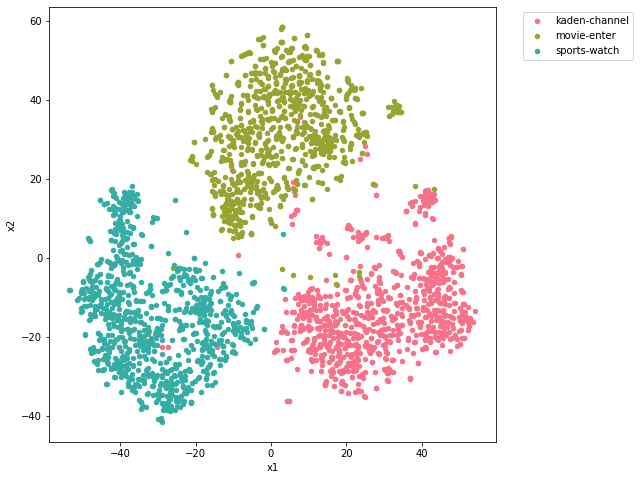

In [34]:
visualize_vectors(vectors=bert_vectors, labels=categories)